## 나의 첫 번째 캐글 경진대회
### House Price Prediction 2021
***
### 학습 전제
- 정형 데이터를 활용해 EDA와 간단한 분류, 회귀 문제를 해결해본 적이 있다.  
- numpy, pandas, matplotlib을 활용해 정형 데이터를 자유자재로 다룰 수 있다.  
- 정형 데이터를 활용해 다양한 모델을 학습시켜보고, 예측 결과를 도출하는 것까지의 과정을 코드로 진행할 수 있다.  

### 학습 목표
- 데이터 사이언스 관련 최대 커뮤니티인 캐글의 경진대회에 직접 참여해서 문제를 해결해본다.  
- 캐글에서 데이터를 내려받는 것으로부터 시작해서, 로컬 서버에서 자유롭게 다루어보며 문제 해결을 위한 고민을 해본다.  
- 앙상블 기법의 개념과 강점을 이해하고, 여러 모델의 예측 결과를 Averaging 한 최종 결과로 캐글에 제출해본다.  
- 하이퍼 파라미터 튜닝의 필요성과 의미를 이해하고, Grid Search, Random Search 등의 기법을 알아본다.  
- Grid Search 기법을 활용해서 직접 하이퍼 파라미터 튜닝 실험을 해보고, 모델의 성능을 최대한 끌어올려본다.  
***
### 평가항목
**1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?**  
-데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다.  

**2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?**  
-제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.  

**3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?**  
-다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.  
***
### 들어가며
이 프로젝트는 전체적인 흐름은 캐글코리아의 [
House Price Prediction EDA (updated 2019.03.12)-김현우님의 커널](https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12/notebook)을 참고하였고,  
데이터 전처리관련해서는 [Default EDA - Stacking Introduction-ym님](https://www.kaggle.com/yeonmin/default-eda-stacking-introduction),  
[부자/가난 동네와의 거리 중요성(feat.GroupByZipcode)-장홍진님](https://www.kaggle.com/reddust/feat-groupbyzipcode),  
[Geo Data EDA And Feature Engineering-허태명님](https://www.kaggle.com/tmheo74/geo-data-eda-and-feature-engineering)의 커널을 참고하였습니다.
### 목차
```
1) 데이터 탐색
    - 데이터 불러오기
    - 데이터간 상관관계 분석
2) 데이터 전처리
    - 결측치 확인
    - 이상치 확인 및 처리
    - 정규화
    - 변수생성
3) 모델링
4) 참고커널
5) 마치며
```

In [1]:
# 필요한 라이브러리 import
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# data 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

### 1. 데이터 탐색
**-데이터 불러오기**  
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.

In [3]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


학습을 위한 데이터의 변수들을 살펴보면 아래와 같습니다.
```
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트 (집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트 (집을 재건축했다면, 변화가 있을 수 있음)
```

In [5]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


테스트하기 위한 데이터를 확인해보니 예측해야할 변수인 price가 없는 것을 확인할 수 있습니다.
```
train data dim : (15035, 21)
sub data dim : (6468, 20)
```
위에서 확인한 data의 shape에서 21개의 변수를 확인할 수 있었고,
테스트하기 위한 데이터에는 price가 빠진 20개의 변수를 확인할 수 있었습니다.
공통적으로 date에서 년도와 해당 월 까지만 필요하다고 판단되어 차후에 전처리 시 적용하도록 하겠습니다.
***
**-데이터간 상관관계 분석**  

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement' 'waterfront'
 'yr_renovated' 'yr_built' 'sqft_lot' 'long' 'sqft_lot15' 'id' 'condition'
 'zipcode']


<AxesSubplot:>

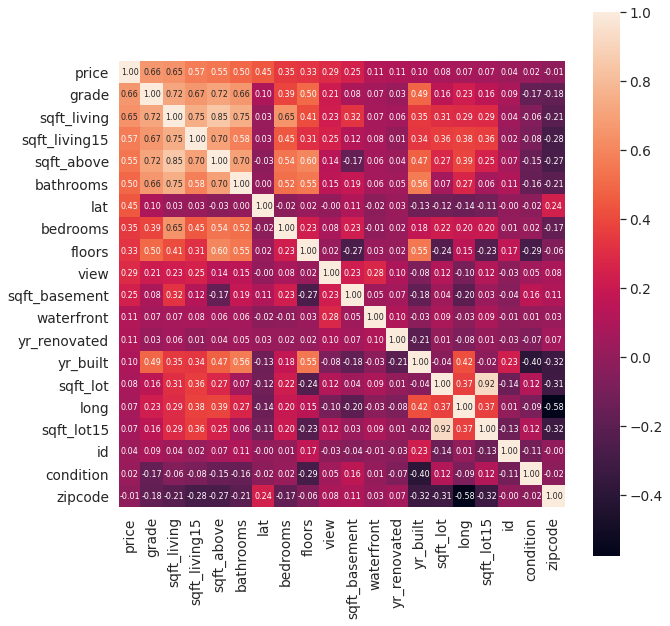

In [6]:
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=21, columns='price').index # price과 correlation이 높은 순서대로(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 21 x 21
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

가격(price)를 기준으로 봤을 때,   
```
1) grade  
2) sqft_living  
3) sqft_living15  
4) sqft_adove  
5) bathrooms  
6) lat
7) bedrooms  
8) view 
...
```
등의 순으로 상관성이 높았습니다.  
  
여기서 lat은 위도를 뜻하는데, 집값을 분석한 데이터에 나온 지역이 시애틀인데 시애틀의 경우 북쪽으로 갈수록 살기 좋은 집들이 많아 집값에 영향을 끼친다고 합니다.  

가격에 영향을 미친 순서로 확인해 보았을 때 집의 등급도 영향을 끼치지만 방의 갯수나 면적(지하실을 제외한 실 면적, 지하실 면적)도 상당히 영향을 끼치는 것을 확인할 수 있습니다.  

변수에 총 면적과 방의 총 갯수를 추가해보는 것도 좋은 방법일 것 같습니다.

또한 renovated(재건축)이후의 면적인 sqft_living15가 높은 영향력을 가진 것으로 보아 재건축 여부가 결과값에 좋은 영향을 끼칠 수 있을 것 같습니다.

거기다 재건축 하지 않았을 때에는 yr_renovated가 0으로 들어가있는데,  
이를 재건축 시에는 재건축년도로 재건축하지 않았을 시에는 건축년도로 수정해 놓으면 좋을 것 같습니다.

### 2. 데이터 전처리
**-결측치 확인**  
먼저 데이터에 결측치가 있는지를 확인하겠습니다.
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

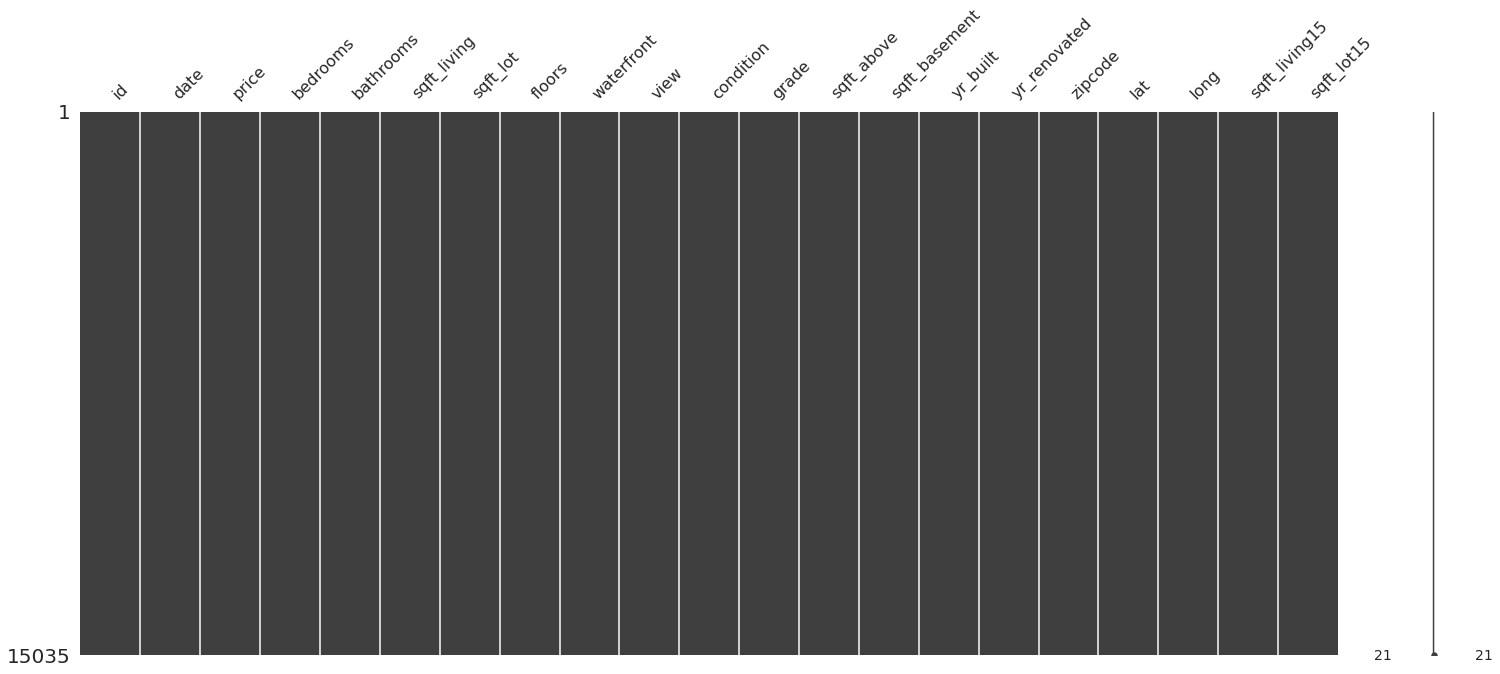

In [7]:
msno.matrix(train)

출력된 시각화한 데이터를 확인해 보았을 때 결측치가 없는 것을 확인할 수 있습니다.  
혹시 모르니 직접 결측치의 개수를 출력해서 확인해보도록 하겠습니다.

In [8]:
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [9]:
for c in test.columns:
    print('{} : {}'.format(c, len(test.loc[pd.isnull(test[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


학습데이터와 테스트데이터 모두 결측치가 없는 것을 확인할 수 있습니다. 

***
**-변수정리**  
위에서 확인하였듯이 date의 경우 해당 월까지만 필요하다고 판단되므로 해당칼럼을 수정하여 정리하도록 하겠습니다.
id 또한 학습에 불필요하므로 삭제하여야 하지만 이상치 등을 확인하여 제거하는데 유용한 키역할을 하므로 차후에 제거하도록 하겠습니다.

In [10]:
train['date'] = train['date'].apply(lambda x : str(x[:6]))
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [11]:
test['date'] = test['date'].apply(lambda x : str(x[:6]))
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


***
**-이상치 확인 및 처리**  
이제 상관관계가 높은 변수들중 첫번째와 두번째 변수들과 price 각각의 관계를 살펴보고 이상치가 있는가 판단해 보겠습니다.

(1) price-grade

<AxesSubplot:xlabel='grade', ylabel='price'>

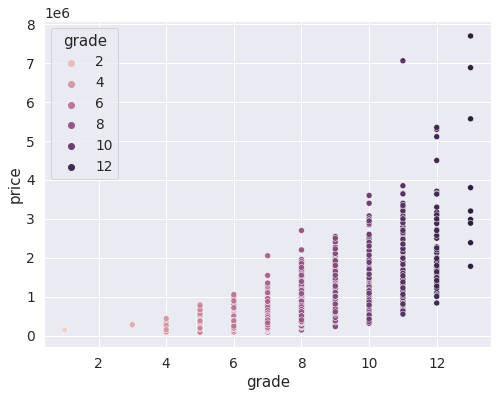

In [12]:
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=train , x='grade', y='price', hue='grade')

grade가 11임에도 불구하고 grade 13에 최상위급의 가격과 동일한 집이 있습니다.  
해당 데이터를 확인해보고 특이점이 있는지 살펴보겠습니다.

In [13]:
train.loc[(train['price'] > 7000000) & (train['grade']==11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,201406,7062500.0,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


해당 데이터는 id:2775인 데이터인데 부지(sqft_lot)가 넓고 waterfront인 집인 것 같습니다. 하지만 우리는 위에서 살펴봤듯이 해당 변수들이 price에 크게 영향을 끼치지는 않는다고 판단했습니다. 따라서 id:277d의 데이터는 이상치로 판단되므로 제거하도록 하겠습니다.

In [14]:
train = train.loc[train['id']!=2775]

(2) sqft_living

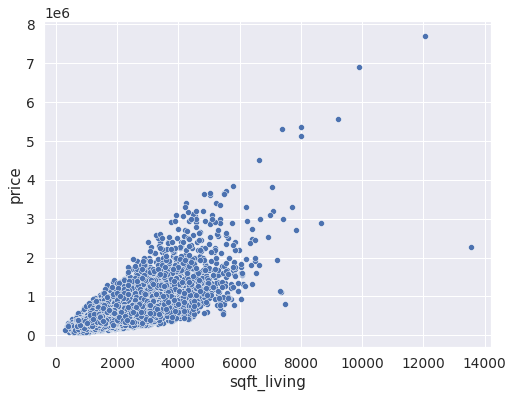

In [15]:
train1 = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x='sqft_living', y="price", data=train1)

가격에 비해 sqft_living이 비정상적으로 큰 데이터가 있습니다. 12000대의 값을 가지고 있는 직전 데이터에 비해 가격이 터무니없이 낮습니다. 확인해보도록 하겠습니다.

In [16]:
train.loc[(train['price'] > 2000000) & (train['sqft_living']>12000)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5108,5108,201410,7700000.0,6,8.0,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
8912,8912,201405,2280000.0,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


이상치라고 판단되는 데이터는 id:8912이며, 직전 데이터는 id:5108입니다.  
grade도 비슷하지만 sqft_lot이 비정상적으로 크고 그에반해 가격은 비정상적으로 낮습니다.  
이상치라 판단하고 삭제하도록 하겠습니다.

In [17]:
train = train.loc[train['id']!=8912]

(3) lot & long  
위의 상관관계에서 위도가 상당한 영향을 끼치는 것을 확인하였습니다.  
이를 그래프로 확인해 보고자 합니다.

<AxesSubplot:xlabel='long', ylabel='lat'>

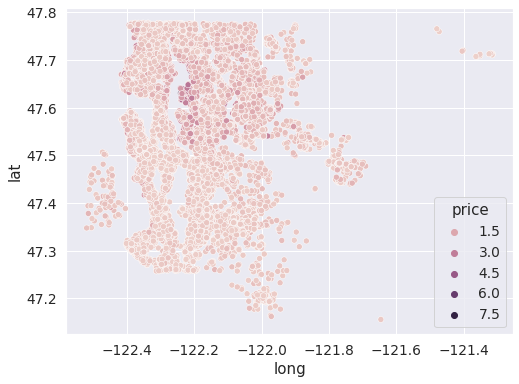

In [18]:
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot('long','lat',hue='price',data=train)

그래프에서 확인해보면 위도 47.5 ~ 47.7 / 경도 -122.4 ~ -122.0을 기준으로 집값 분포가 확연히 차이나는 것을 알 수 있습니다.  
이는 변수로서 활용할 수 있을 것 같습니다.  
위도와 경도 그래프에 우편번호를 적용시켜서도 확인해 보겠습니다.

In [19]:
train['zipcode'] = train['zipcode'].astype(str)
train['zipcode'] = 'z_' + train['zipcode']

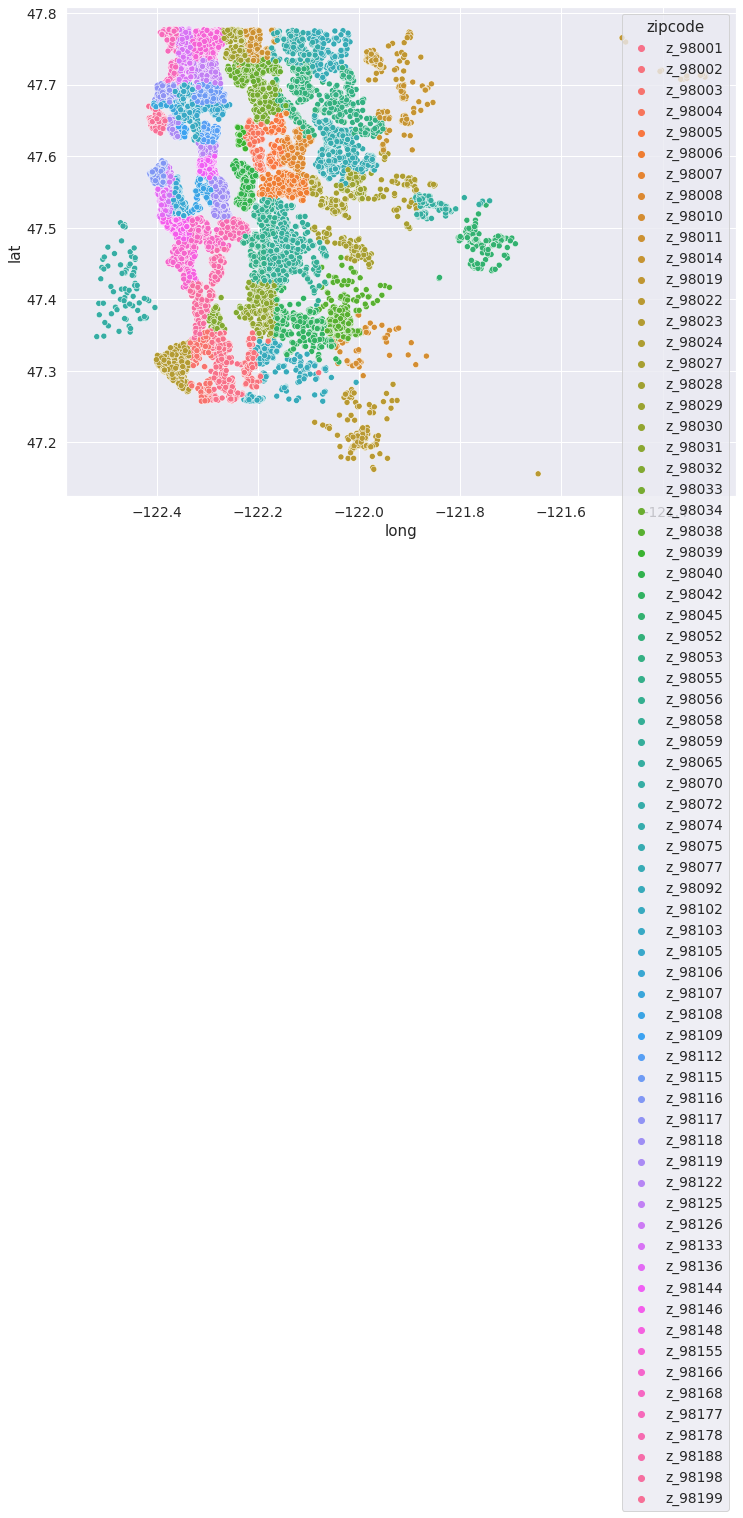

In [20]:
f, ax = plt.subplots(figsize=(12, 9))
sns.scatterplot(x='long', y='lat', hue='zipcode', hue_order=np.sort(train['zipcode'].unique()), data=train);

In [21]:
train['zipcode'] = train['zipcode'].str[2:]

색이 너무 많아 보기 어렵지만 위도와 경도가 가격에 영향을 끼친다고했으니,  
zipcode또한 영향력을 행사한다고 볼 수 있습니다.  
허태명님은 이 zipcode를 쪼개서 여러가지 방법으로 새로운 feature를 생성하였습니다.  
이를 참고하여 변수를 생성해보겠습니다.
***
**-정규화**  
이제 데이터의 그래프 분포를 보고 정규화하겠습니다.  
한꺼번에 정규화하기 위해 학습데이터와 테스트데이터를 합쳐 진행하겠습니다.

In [22]:
# price는 따로 저장합니다.
y_train = train['price']
del train['price']

In [23]:
# 차후 모델학습시에는 다시 분리해야하므로 개수를 확인합니다.
train_len = len(train)
data = pd.concat((train, test), axis=0)

In [24]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


그래프를 확인할때 필요없는 id칼럼도 제거합니다.  
나중에 예측 결과를 제출할 때를 대비해 따로 저장해 둡니다.

In [25]:
test_id = data['id'][train_len:]
del data['id']

베이스라인에서 확인한 치우쳐진 분포를 가진 변수들를 로그변환을 통해 정규분포에 가깝게 만듭니다.

In [26]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

***
**-변수추가**  
위의 상관관계 분석 시에 추가 및 변경해야 할 부분들을 적용시켜 줍니다.  
참고한 커널들에서 활용할만한 변수들을 참고하였습니다.

In [27]:
# 방의 총 갯수 변수 추가
data['total_rooms'] = data['bedrooms'] + data['bathrooms']

# 건물 전체 연면적 추가
data['sqft_total_size'] =data['sqft_above'] + data['sqft_basement']

# 총 사용면적 추가
data['sqft_total'] = data['sqft_living'] + data['sqft_lot']

# 재건축 후 총 면적 변수 추가
data['sqft_total15'] = data['sqft_living15'] + data['sqft_lot15']

# 전체 부지에서 사용면적 비율
data['sqft_total_by_lot'] = (data['sqft_living'] + data['sqft_above'] + data['sqft_basement'])/data['sqft_lot']

# yr_renovated 변수 변경
data['yr_renovated'] = data['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
data['yr_renovated'] = data['yr_renovated'].fillna(data['yr_built'])

# 재건축 여부 변수 추가
data['is_renovated'] = data['yr_renovated'] - data['yr_built']
data['is_renovated'] = data['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
data['date'] = data['date'].astype('int')

# 면적 대비 거실의 비율 
data['sqft_ratio_1'] = data['sqft_living'] / data['sqft_total_size']

data['sqft_ratio15'] = data['sqft_living15'] / data['sqft_lot15'] 

# 위도가 47.5이상 47.7이하 여부 변수 추가
data['is_middle_lat'] = data['lat'].apply(lambda x : 1 if x > 47.5 and x < 47.7 else 0)

# 경도가 -122.0이하 -122.4이상 여부 변수 추가
data['is_middle_long'] = data['long'].apply(lambda x : 1 if x > -122.4 and x < -122.0 else 0)

In [28]:
data['zipcode'] = data['zipcode'].astype(str)
# 45, 5, 35, 4
data['zipcode-3'] = 'z_' + data['zipcode'].str[2:3]
data['zipcode-4'] = 'z_' + data['zipcode'].str[3:4]
data['zipcode-5'] = 'z_' + data['zipcode'].str[4:5]
data['zipcode-34'] = 'z_' + data['zipcode'].str[2:4]
data['zipcode-45'] = 'z_' + data['zipcode'].str[3:5]
data['zipcode-35'] = 'z_' + data['zipcode'].str[2:3] + data['zipcode'].str[4:5]

le = LabelEncoder()
data['zipcode'] = le.fit_transform(data['zipcode'])
data['zipcode-3'] = le.fit_transform(data['zipcode-3'])
data['zipcode-4'] = le.fit_transform(data['zipcode-4'])
data['zipcode-5'] = le.fit_transform(data['zipcode-5'])
data['zipcode-34'] = le.fit_transform(data['zipcode-34'])
data['zipcode-45'] = le.fit_transform(data['zipcode-45'])
data['zipcode-35'] = le.fit_transform(data['zipcode-35'])

In [29]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_ratio_1,sqft_ratio15,is_middle_lat,is_middle_long,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,...,1.0,0.237168,1,1,1,7,8,16,54,16
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,...,1.0,0.337385,0,1,0,2,8,2,24,8
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,...,1.0,0.239904,1,1,0,7,4,7,51,4
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,...,1.0,0.328201,0,1,0,0,3,0,2,3
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,...,1.0,0.169910,0,1,1,9,8,18,57,16


이제 data를 다시 나눠줍니다.

In [30]:
test = data.iloc[train_len:, :]
x_train = data.iloc[:train_len, :]

In [31]:
x_train

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_ratio_1,sqft_ratio15,is_middle_lat,is_middle_long,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,...,1.000000,0.237168,1,1,1,7,8,16,54,16
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,...,1.000000,0.337385,0,1,0,2,8,2,24,8
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,...,1.000000,0.239904,1,1,0,7,4,7,51,4
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,...,1.000000,0.328201,0,1,0,0,3,0,2,3
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,...,1.000000,0.169910,0,1,1,9,8,18,57,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,1.609438,2.50,7.832411,8.703507,2.0,0,0,3,9,...,1.000000,0.418396,1,1,0,5,6,5,43,6
15031,201503,1.609438,3.50,8.163656,8.881975,2.0,0,0,3,9,...,0.556176,0.330645,1,1,1,3,6,12,31,14
15032,201405,1.386294,2.50,7.333676,7.031741,3.0,0,0,3,8,...,1.000000,1.013917,1,1,1,0,3,9,2,11
15033,201502,1.609438,2.50,7.745436,8.668024,2.0,0,0,3,8,...,1.000000,0.254167,1,1,1,4,6,13,38,14


위에서 나누어주었던 price도 한쪽으로 치우쳐져있으니 이를 로그변환해줍니다.

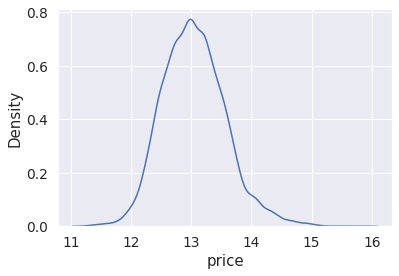

In [32]:
y_train = np.log1p(y_train)

sns.kdeplot(y_train)
plt.show()

In [33]:
# 차후 변환을 위해 함수 생성
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [34]:
x_train['date'] = pd.to_numeric(x_train['date'])
test['date'] = pd.to_numeric(test['date'])

### 3. 모델링
여러가지 모델의 RMSLE결과를 확인한 후 최적의 하이퍼 파라미터를 찾겠습니다.
원래 계획은 이를 활용하여 앙상블을 하는 것이었으나,  
앙상블결과가 오히려 안좋은 경우가 있어 모델 하나만으로 진행하겠습니다.

In [35]:
random_state=2020
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb.XGBRegressor(random_state=random_state)
lightgbm = lgb.LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [36]:
def get_scores(models, train, y):
    # 답안 작성
    df = {}
    for model in models:
      # 모델 이름 획득
      model_name = model.__class__.__name__

      # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
      X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

      # 모델 학습
      model.fit(X_train, y_train)

      # 예측
      y_pred = model.predict(X_test)

      # 예측 결과의 rmse값 저장
      df[model_name] = rmse(y_test, y_pred)

      # data frame에 저장
      score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df
    
get_scores(models, x_train, y_train)

,RMSE
RandomForestRegressor,128230.097884
GradientBoostingRegressor,128133.407770
LGBMRegressor,113308.083571
XGBRegressor,113018.558703


확인결과 lgbm모델이 RMSE값은 작은 것이 성능이 좋은 것이므로,  
lGBRegressor를 사용하여 하이퍼파라미터를 조정하고 결과값을 제출하겠습니다.

In [37]:
# 하이퍼파라미터를 찾기위한 gridsearch함수
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

**-LGBMRegressor**

In [38]:
param_grid = {
    'learning_rate' : [0.1, 0.05], 'n_estimators': [1000, 1500, 2000],
    'max_depth': [50, 100,200], 'colsample_bytree' : [1.0, 0.8, 0.7],
}

lightgbm = lgb.LGBMRegressor(random_state=random_state)
my_GridSearch(lightgbm, x_train, y_train, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   25.8s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 270 out of 270 | elapsed:  3.3min finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,colsample_bytree,learning_rate,max_depth,n_estimators,score,RMSLE
51,0.7,0.05,200,1000,-0.025900,0.160934
48,0.7,0.05,100,1000,-0.025900,0.160934
45,0.7,0.05,50,1000,-0.025900,0.160934
27,0.8,0.05,50,1000,-0.025988,0.161207
33,0.8,0.05,200,1000,-0.025988,0.161207
30,0.8,0.05,100,1000,-0.025988,0.161207
49,0.7,0.05,100,1500,-0.026041,0.161371
46,0.7,0.05,50,1500,-0.026041,0.161371
52,0.7,0.05,200,1500,-0.026041,0.161371
9,1.0,0.05,50,1000,-0.026159,0.161737


gridsearch를 통해 확인한  
'learning_rate' : 0.05, 'n_estimators': 2000,
'max_depth': 50, 'colsample_bytree' : 0.7
값을 모델에 적용해 줍니다.  
가장 좋은 n_estimators값은 1000이지만 제출해본 결과 2000이 점수가 더 좋아 2000으로 결정하였습니다.

In [39]:
lightgbm = lgb.LGBMRegressor(colsample_bytree=0.7,
                             learning_rate=0.05, max_depth=200, 
                             n_estimators=2000, random_state=random_state)

In [40]:
# 제출을 위한 함수작성
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [41]:
save_submission(lightgbm, x_train, y_train, test, 'LGB', '0.1605')

/home/aiffel/aiffel/kaggle_kakr_housing/data/submission_LGB_RMSLE_0.1605.csv saved!


### 4. 결과제출
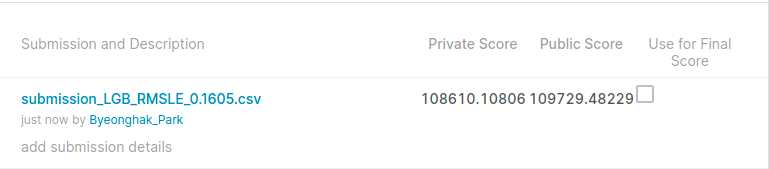

**Private Scorer : 108610.10806**
***

### 5. 참고커널
[House Price Prediction EDA (updated 2019.03.12)-김현우님의 커널](https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12/notebook)  
[Default EDA - Stacking Introduction-ym님](https://www.kaggle.com/yeonmin/default-eda-stacking-introduction)  
[부자/가난 동네와의 거리 중요성(feat.GroupByZipcode)-장홍진님](https://www.kaggle.com/reddust/feat-groupbyzipcode)  
[11th Solution: Public 98316, Private 99336-허태명님](https://www.kaggle.com/tmheo74/11th-solution-public-98316-private-99336)  

***
  
### 6. 마치며
**살면서 처음으로 시도해본 캐글프로젝트였다.  
비록 진짜 제출은 아니었지만 그래도 점수를 올리기위해서 고심하고 여러가지 커널들을 찾아보고 적용해보았던 경험은 신선했다.  
이 프로젝트를 시작하고 일주일 뒤에 바로 해커톤이 시작되었다.  
맛만보고 진행하게 된 해커톤이라 무엇을 해야할지도 막막하고 깜깜했다.  
그래도 집값예측 캐글 프로젝트를 하면서 이런저런 커널들을 찾아보고 자료를 조사해봤던 경험들이 도움이 되었다.  
비록 점수는 좋지 않지만 그래도 뜻깊은 해커톤이었고, 집값예측 캐글 프로젝트였다.**